# What can you do to improve Airbnb business?

This is the project of Udacity's data scientist nanodegree program (Term2, Project1).  
In this project, we are required to analysis data with **CRISP-DM** process. The CRISP-DM process is below.

#### CRISP-DM (Cross-Industry Standard Process for Data Mining)
- Business Understanding
- Data Understanding
- Data Preparation
- Modeling
- Evaluation
- Deployment

So, in this kernel I analysis data with following this process.

## Business Understanding

Airbnb is a platform of accommodation which match the needs of staying and of lending.  
Their main source of income is **fee for host**. Basically, as the number of transactions between the host and the guest increases, their profit also increases.  
So, It is important to their business and I expect it to be one of their KPIs.


<img src="https://bmtoolbox.net/wp-content/uploads/2016/06/airbnb.jpg" width=700>

ref: https://bmtoolbox.net/stories/airbnb/

#### What can we do to increase the transactions?
I considered three below questions to explore its way.

* **How long is the period available for lending by rooms?**  
Is there rooms which is available all for years? or almost rooms are available on spot like one day or one week?  
Here, I want to know the trend in the outline of the data.

* **Is there a busy season?**  
If the demand for accommodation is more than the number of rooms available for lending, it leads to the loss of business opportunities.  
So, I want to know whether is there the busy season. If this is true, we must create a mechanism to increase the number of rooms available for lending during the busy season.

* **Are there any trends of popular rooms?**  
If this question's answer is true, we can suggest host to ways make the room easier to rent.  
In this part, I'll use machine learning technique.

## Data Understanding

We have three data.

* `listings`: including full descriptions and average review score
* `calendar`: including listing id and the price and availability for that day
* `reviews`: including unique id for each reviewer and detailed comments

In this part, I'll make some visualization and aggregation to understand the charactoristics of the data.

In [1]:
# import necessary package
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score


%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [4]:
# load data
seattle_calendar = pd.read_csv('../dataset/calendar.csv')
seattle_listing = pd.read_csv('../dataset/listings.csv')
seattle_review = pd.read_csv('../dataset/reviews.csv')

### calendar

Let's look first 5 row of the data and column information.

In [5]:
seattle_calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [6]:
seattle_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null object
available     1393570 non-null object
price         934542 non-null object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


There are 4 columns.  
Here, I found some charactoristics of the data.

* Not only available days are stored in data, it seems to be stored not available days.
* If the `available` values are `f`, the `price` values seems to be `NaN`. 
* The `price` values are stored as object, not integer. This is caused the value stored like `$xx.xx`, and it is necessary to transform this column.

In response to the result, now I have two question .

1. If the available values are f, the price values seems to be NaN. But it is only a hypothesis, is it true all data?
2. How many rows per each listing_id?

Let's answer these questions with exploring data.

In [7]:
#  If the available values are f, the price values seems to be NaN. But it is only a hypothesis, is it true all data?
calendar_q1_df = seattle_calendar.groupby('available')['price'].count().reset_index()
calendar_q1_df.columns = ['available', 'price_nonnull_count']
calendar_q1_df

,available,price_nonnull_count
0,f,0
1,t,934542


In [8]:
#  How many rows per each listing_id?
calendar_q2_df = seattle_calendar.groupby('listing_id')['date'].count().reset_index()
calendar_q2_df['date'].value_counts()

365    3818
Name: date, dtype: int64

Above, I can answer my question. The answer is

***If the available values are f, the price values seems to be NaN. But it is only a hypothesis, is it true all data?***  
-> true !!

***How many rows per each listing_id?***  
-> 365 days record. This is equal a year.

Now, I almost understood the features of the data.  
Finally, I'll research is there any trend of the listings price.

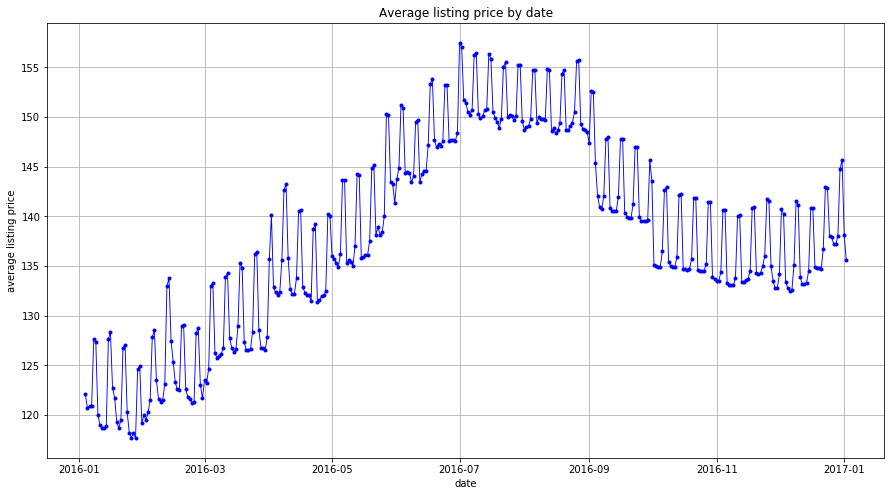

In [54]:
# process data
calendar_q3_df = seattle_calendar.copy(deep=True)
calendar_q3_df.dropna(inplace=True)
calendar_q3_df['date'] = pd.to_datetime(calendar_q3_df['date'])
calendar_q3_df['price'] = calendar_q3_df['price'].map(lambda x: float(x[1:].replace(",", "")))

# apply aggregation
calendar_q3_df = calendar_q3_df.groupby('date')['price'].mean().reset_index()

# plot avg listings prices over time.
plt.figure(figsize=(15, 8))
plt.plot(calendar_q3_df.date, calendar_q3_df.price, color='b', marker='.', linewidth=0.9)
plt.title("Average listing price by date")
plt.xlabel('date')
plt.ylabel('average listing price')
plt.grid()

This is interesting.  
There are two trend of the data.

1. The average price rise from 2016/1 to 2016/7, and reach peak for three months, and getting lower. And the average proce of 2017/1 is higher than 1 years ago.
2. There is periodic small peak.

The first trend can be split into two foctors. One is seasonal factor, and the other is overall factor.  
The second trend looks like a weekly trend, so let's close look at!!

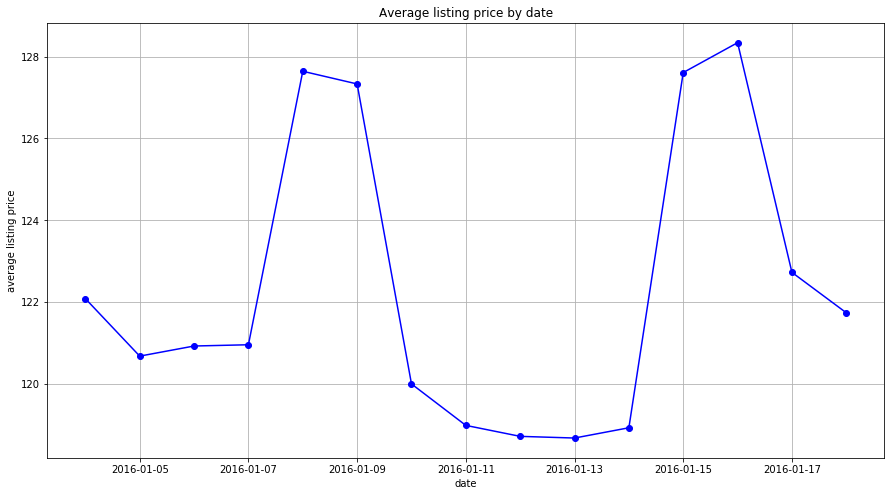

In [55]:
# plot more narrow range
plt.figure(figsize=(15, 8))
plt.plot(calendar_q3_df.date.values[:15], calendar_q3_df.price.values[:15], color='b', marker='o', linewidth=1.5)
plt.title("Average listing price by date")
plt.xlabel('date')
plt.ylabel('average listing price')
plt.grid()

It looks like a weekly trend as I thought.  
Then, which does weekday have high price? 

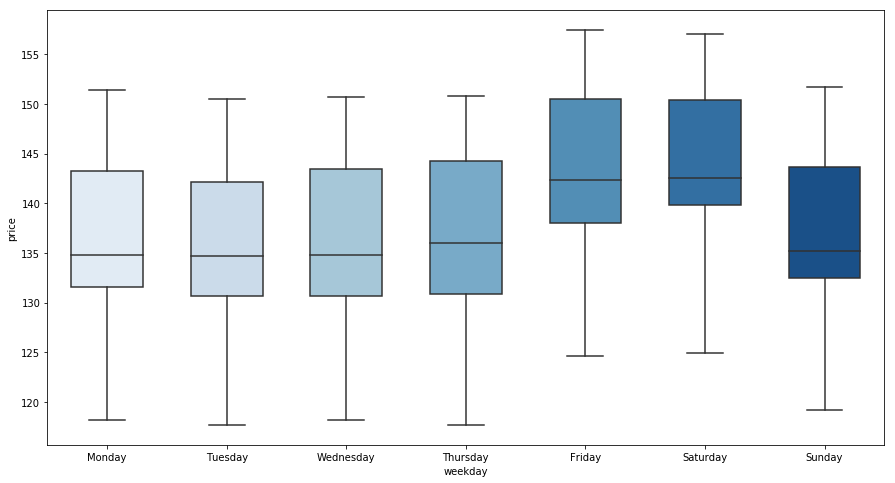

In [11]:
# create weekday column
calendar_q3_df["weekday"] = calendar_q3_df["date"].dt.weekday_name

# boxplot to see price distribution
plt.figure(figsize=(15, 8))
sns.boxplot(x = 'weekday',  y = 'price', data = calendar_q3_df, palette="Blues", width=0.6)
plt.show()

The weekend, Friday and Saturday has high prices. 

#### Summary

* Each listings has `365` days record in this data.
* If `available` values are `f`, the `price` values are `NaN`.
* There is the weekly trend which the listing prices in weekend are higher than other weekday.

### listings

Let's begin with looking at first 5 row of the data and columns information.

In [12]:
seattle_listing.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [13]:
print(list(seattle_listing.columns.values))

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'gues

There are many columns, so I can't explore each columns here.  
Here I'll look at some columns of my interest.

First, I'll investigate how many listings are in the data.

In [14]:
print("Num of listings: ", seattle_listing.id.count())
print("Num of rows: ", seattle_listing.shape[0])

Num of listings:  3818
Num of rows:  3818


This shows the each rows represents unique listings.

Next, I am interested in below columns.

* review_scores_rating
* price
* maximum_nights

What is the distribution of these values in each columns? Is the distribution skewed or normal?  
Let's look at!

#### review_scores_rating

In [15]:
seattle_listing['review_scores_rating'].describe().reset_index()

,index,review_scores_rating
0,count,3171.000000
1,mean,94.539262
2,std,6.606083
3,min,20.000000
4,25%,93.000000
5,50%,96.000000
6,75%,99.000000
7,max,100.000000


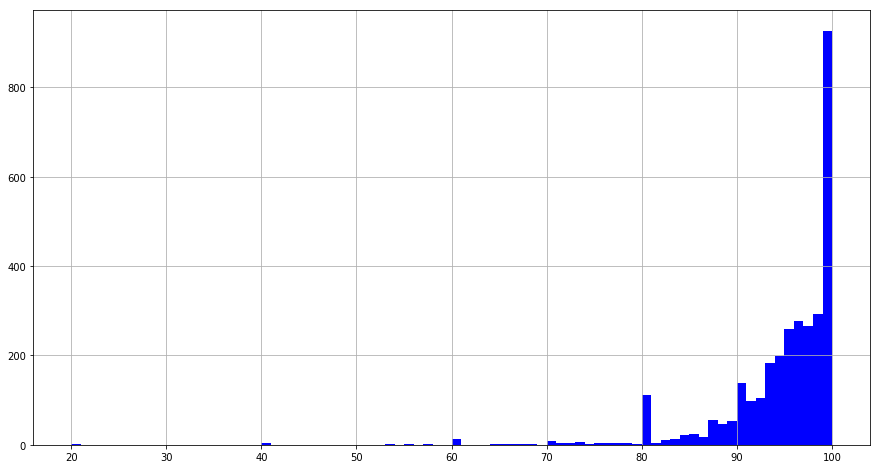

In [16]:
# cleaning data
listings_q1_df = seattle_listing['review_scores_rating'].dropna()

# plot histgram
plt.figure(figsize=(15, 8))
plt.hist(listings_q1_df.values, bins=80, color='b')
plt.grid()

This is very right skewed distribution.  
The 75% or more values are 90 points. And the most common thing is 100 points.  
I can say the low score listings are minolity.

#### price

In [17]:
# cleaning data
listings_q2_df = seattle_listing.copy(deep=True)
listings_q2_df = listings_q2_df['price'].dropna().reset_index()
listings_q2_df['price'] = listings_q2_df['price'].map(lambda x: float(x[1:].replace(',', '')))

listings_q2_df['price'].describe().reset_index()

,index,price
0,count,3818.000000
1,mean,127.976166
2,std,90.250022
3,min,20.000000
4,25%,75.000000
5,50%,100.000000
6,75%,150.000000
7,max,1000.000000


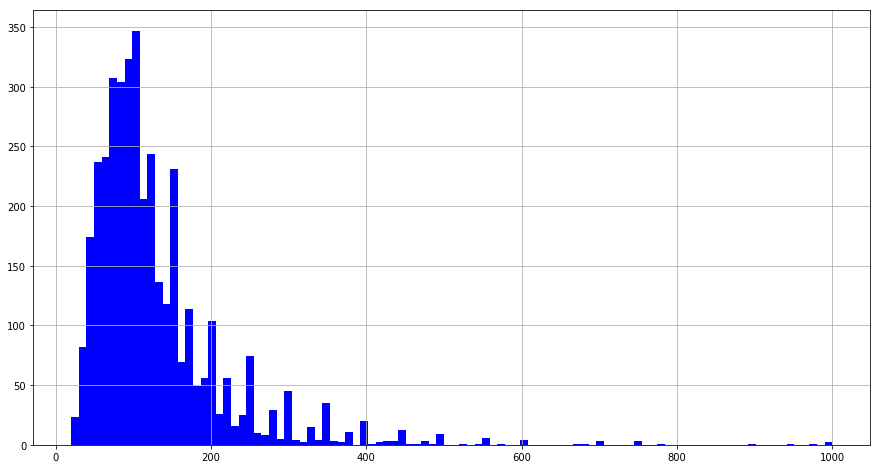

In [18]:
plt.figure(figsize=(15, 8))
plt.hist(listings_q2_df.price, bins=100, color='b')
plt.grid()

This is long tail distribution.  
Almost values are from 0 to 200.

#### maximum_nights

In [19]:
seattle_listing['maximum_nights'].describe().reset_index()

,index,maximum_nights
0,count,3818.000000
1,mean,780.447617
2,std,1683.589007
3,min,1.000000
4,25%,60.000000
5,50%,1125.000000
6,75%,1125.000000
7,max,100000.000000


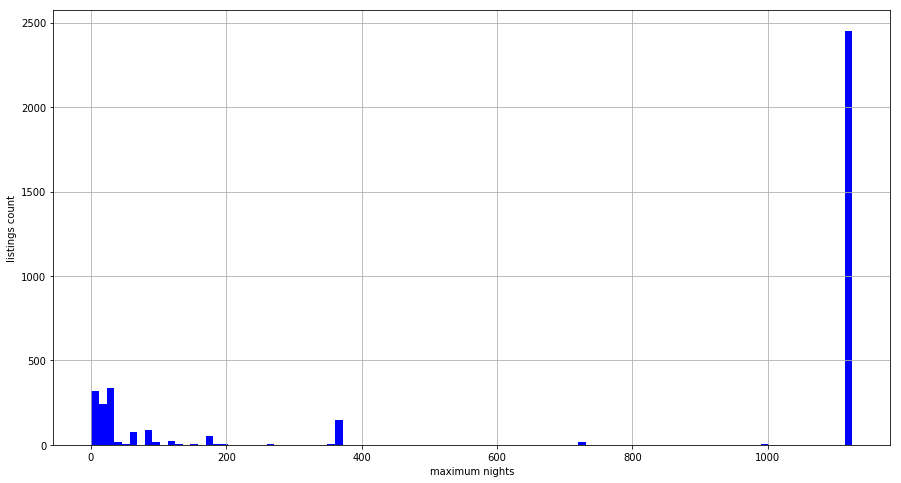

In [50]:
# eliminate outliers because maximum values are very large.
listings_q3_df = seattle_listing[seattle_listing['maximum_nights'] <= 1500]

plt.figure(figsize=(15, 8))
plt.hist(listings_q3_df.maximum_nights, bins=100, color='b')
plt.xlabel('maximum nights')
plt.ylabel('listings count')
plt.grid()

This is very surprising because I expect it would be a week at most.  
In fact, almost `maxmum_night` values are setted 1125.   
I have not used Airbnb so I don't know, but maybe there may be something like the default value.  
Or there maybe two segments, one is `spot available listings`, the other is `long term listings like normal rent`. 

#### Summary

* The listings data has 92 columns.
* The `review_scores_rating` has right skewed distribution, and almost values are over 90 points.
* The `price` has long tail distribution, almost values are around 100\$ but some values are much higher than other values.  
* The `maximum_nights` has very special distribution. Their are two segments, one is about 3 years, the other is around 1week.

OK, let's look at last data.

### reviews

Let's begin with looking at first 5 row of the data and columns information.

In [21]:
seattle_review.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [22]:
seattle_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
listing_id       84849 non-null int64
id               84849 non-null int64
date             84849 non-null object
reviewer_id      84849 non-null int64
reviewer_name    84849 non-null object
comments         84831 non-null object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


There are six columns, such as listing_id that received review, id of reviews, when review submitted, and so on.  
I'm concerned that there are no review scores here. I think it might be in comments, so let's confirm this.

In [23]:
print("sample 1: ", seattle_review.comments.values[0], "\n")
print("sample 2: ", seattle_review.comments.values[3])

sample 1:  Cute and cozy place. Perfect location to everything!  

sample 2:  Close to Seattle Center and all it has to offer - ballet, theater, museum, Space Needle, restaurants of all ilk just blocks away, and the Metropolitan (probably the coolest grocer you'll ever find). Easy to find and Kelly was warm, welcoming, and really interesting to talk to. 


From the above, the review score seems not to be included.

Next, I want to see the time series change of the number of comments.

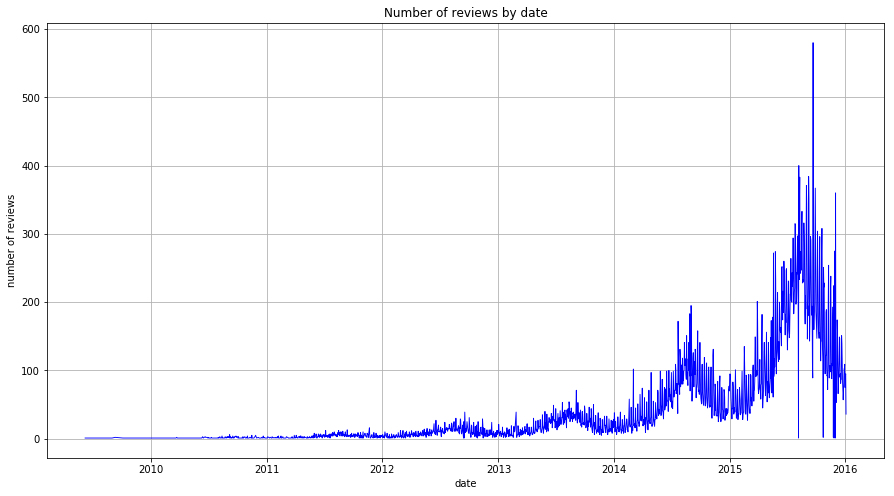

In [52]:
# convert date column's data type to date from object
review_q1_df = seattle_review.copy(deep=True)
review_q1_df.date = pd.to_datetime(review_q1_df.date)

review_q1_df = review_q1_df.groupby('date')['id'].count().reset_index()

# plot avg listings prices over time.
plt.figure(figsize=(15, 8))
plt.plot(review_q1_df.date, review_q1_df.id, color='b', linewidth=0.9)
plt.title("Number of reviews by date")
plt.xlabel('date')
plt.ylabel('number of reviews')
plt.grid()

It is little noisy, but we can see an increase in the number of Airbnb users. (and the date range is wide than calendar data)  
And I realize it seems to have a peak at about the same time of each year.  
So, let's use moving averages to smooth the graph.

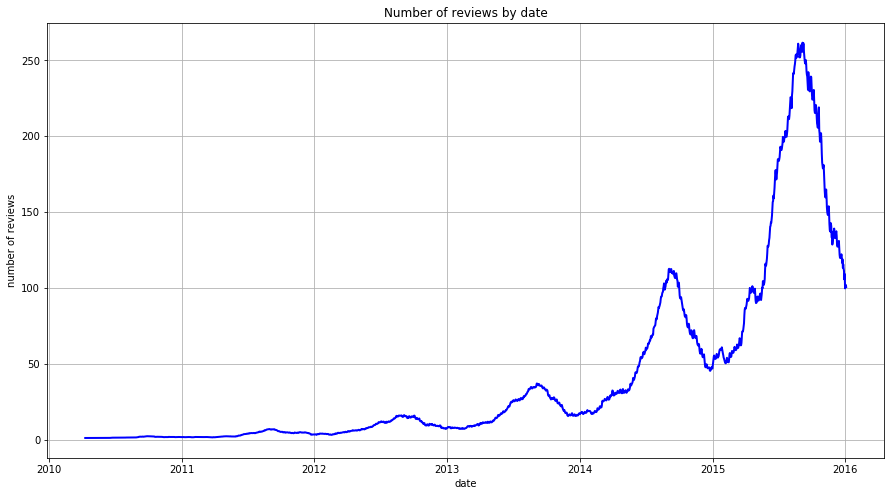

In [53]:
# create rolling mean column
review_q1_df["rolling_mean_30"] = review_q1_df.id.rolling(window=30).mean()

# plot avg listings prices over time.
plt.figure(figsize=(15, 8))
plt.plot(review_q1_df.date, review_q1_df.rolling_mean_30, color='b', linewidth=2.0)
plt.title("Number of reviews by date")
plt.xlabel('date')
plt.ylabel('number of reviews')
plt.grid()

I tried thirty days (about 1 month) window.  
The graph became smooth and the trend became clear, and my belief that the peaks were in the same place became stronger.  
Next, I extract when the peak comes in each year.

In [26]:
review_q1_df["year"] = review_q1_df.date.dt.year
years = review_q1_df.year.unique()

for year in years:
    if year >= 2010 and year < 2016:
        year_df = review_q1_df[review_q1_df.year == year]
        max_value = year_df.rolling_mean_30.max()
        max_date = year_df[year_df.rolling_mean_30 == max_value].date.dt.date.values[0]
        print(year, max_date, np.round(max_value, 1))

2010 2010-10-04 2.3
2011 2011-08-31 7.0
2012 2012-09-04 16.2
2013 2013-09-04 37.0
2014 2014-09-03 112.6
2015 2015-09-05 261.6


My hypothesis is correct.  
The peak seems to be towards the beginning of September!!
Is this summer vacation?

### Answer my Question

Up to this point, I can answer two of the three questions mentioned at the beginning. 
First of all, let's answer from the question.
**How long is the period available for lending by rooms?**

This was shown when investigating listing data. There were two groups in listings. It's a listing available at spots with a maximum nights less than a week and a listing of a sense of renting available for up to three years. 

For a further discussion, plot a scatter plot of maximum nights and minimum nights.

Text(0, 0.5, 'minimum nights')

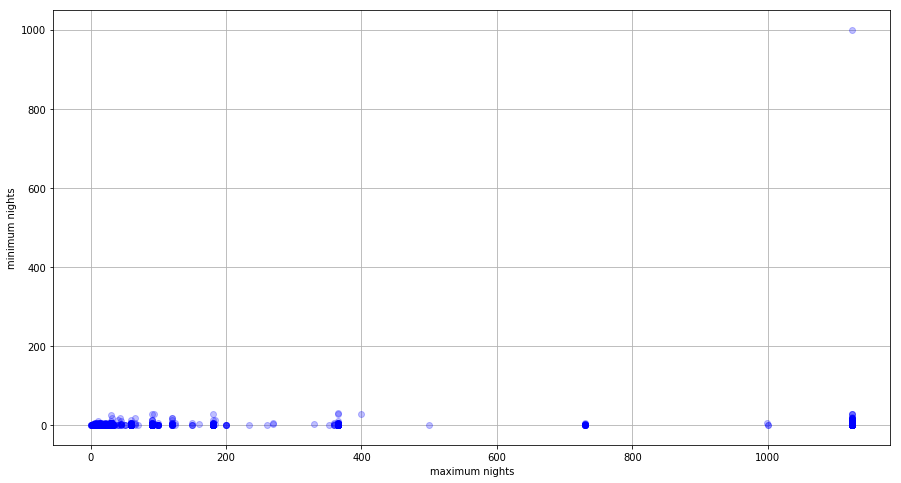

In [51]:
listings_q3_df["min_max_night_diff"] = listings_q3_df.maximum_nights - listings_q3_df.minimum_nights

plt.figure(figsize=(15, 8))
plt.plot(listings_q3_df.maximum_nights, listings_q3_df.minimum_nights, color='b', marker='o', linewidth=0, alpha=0.25)
plt.grid()
plt.xlabel('maximum nights')
plt.ylabel('minimum nights')

From here, it can be seen that the minimum nights is almost constant regardless of the maximum nights.
In other words, it can be seen that listings with a long maximum nights are not rented exclusively for rental, but are widely handled from spot use to long-term stay.

Let's answer the second question.  
**Is there a busy season?**

It can not be said exactly because the actual duration of the user's stay are not included in the data, but the number of reviews is considered to be a guide.
In addition, since periodical peaks appear in the number of reviews annually, it may be considered that the neighborhood is a busy season.

We found that the biggest busy season was the beginning of September, but how long will it be the busy season? Let's look in more detail!

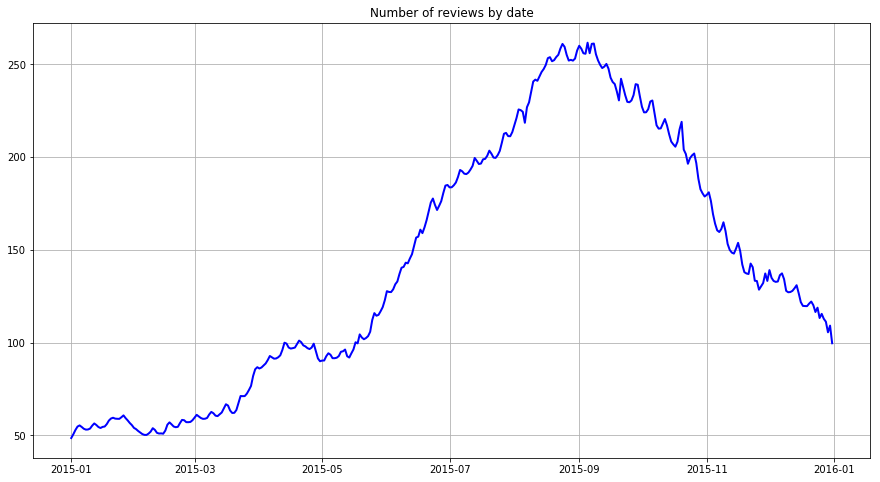

In [28]:
review_q2_df = review_q1_df[review_q1_df.year == 2015]

plt.figure(figsize=(15, 8))
plt.plot(review_q2_df.date, review_q2_df.rolling_mean_30, color='b', linewidth=2.0)
plt.title("Number of reviews by date")
plt.grid()

It's hard to say clearly when to begin and when to end.  
But, from here it may be able to say the busy season is One month before and after from September.

## Data Preparation

From here, I want to answer the last question, **"Are there any trends of popular rooms?"**.  
So, Let's begin to clean and process the listing data.

First, we need to define the target variable 'Popular of listings'. I thought this could be defined as follows.

[Actual number of times rent] / ([Available days from 2016 to 2017] * (2017 - [Year of the listings open]))

Since the number of times the listings are actually rent is considered to be proportional to the number of days the property is available, it needs to be scaled, and Furthermore, since the number is considered to increase the earlier the listings is released to the public, we need to scale there as well.

One thing I can not consider here is the period when the listings was actually rented. The longer the period of rending, the smaller the number of times of rending. However, there are no data to consider this, so I will assume that most of Airbnb users are short-term use. 

First, we start with a check for null values. This is because we can not use columns that has too null values.

In [29]:
prepare_df = seattle_listing.copy(deep=True)

In [30]:
# check null count
df_length = prepare_df.shape[0]

for col in prepare_df.columns:
    null_count = prepare_df[col].isnull().sum()
    if null_count == 0:
        continue
        
    null_ratio = np.round(null_count/df_length * 100, 2)
    print("{} has {} null values ({}%)".format(col, null_count, null_ratio))

summary has 177 null values (4.64%)
space has 569 null values (14.9%)
neighborhood_overview has 1032 null values (27.03%)
notes has 1606 null values (42.06%)
transit has 934 null values (24.46%)
thumbnail_url has 320 null values (8.38%)
medium_url has 320 null values (8.38%)
xl_picture_url has 320 null values (8.38%)
host_name has 2 null values (0.05%)
host_since has 2 null values (0.05%)
host_location has 8 null values (0.21%)
host_about has 859 null values (22.5%)
host_response_time has 523 null values (13.7%)
host_response_rate has 523 null values (13.7%)
host_acceptance_rate has 773 null values (20.25%)
host_is_superhost has 2 null values (0.05%)
host_thumbnail_url has 2 null values (0.05%)
host_picture_url has 2 null values (0.05%)
host_neighbourhood has 300 null values (7.86%)
host_listings_count has 2 null values (0.05%)
host_total_listings_count has 2 null values (0.05%)
host_has_profile_pic has 2 null values (0.05%)
host_identity_verified has 2 null values (0.05%)
neighbourhoo

As you can see, it seems that there are columns 90% or more of the values are null, but most of the columns have between 0-30% of null_ratio. Therefore, here, I decided to excluded from analysis the columns with 30% or more null ratio.

Also, it seems that there are only two null values in `host_since` used to calculate the target variable. This needs to be removed. 

In [31]:
# detect need drop columns
drop_cols = [col for col in prepare_df.columns if prepare_df[col].isnull().sum()/df_length >= 0.3]

# drop null
prepare_df.drop(drop_cols, axis=1, inplace=True)
prepare_df.dropna(subset=['host_since'], inplace=True)

# check after
for col in prepare_df.columns:
    null_count = prepare_df[col].isnull().sum()
    if null_count == 0:
        continue
        
    null_ratio = np.round(null_count/df_length * 100, 2)
    print("{} has {} null values ({}%)".format(col, null_count, null_ratio))

summary has 177 null values (4.64%)
space has 568 null values (14.88%)
neighborhood_overview has 1031 null values (27.0%)
transit has 933 null values (24.44%)
thumbnail_url has 320 null values (8.38%)
medium_url has 320 null values (8.38%)
xl_picture_url has 320 null values (8.38%)
host_location has 6 null values (0.16%)
host_about has 857 null values (22.45%)
host_response_time has 521 null values (13.65%)
host_response_rate has 521 null values (13.65%)
host_acceptance_rate has 771 null values (20.19%)
host_neighbourhood has 298 null values (7.81%)
neighbourhood has 416 null values (10.9%)
zipcode has 7 null values (0.18%)
property_type has 1 null values (0.03%)
bathrooms has 16 null values (0.42%)
bedrooms has 6 null values (0.16%)
beds has 1 null values (0.03%)
cleaning_fee has 1029 null values (26.95%)
first_review has 625 null values (16.37%)
last_review has 625 null values (16.37%)
review_scores_rating has 645 null values (16.89%)
review_scores_accuracy has 656 null values (17.18

Good.  
Next, we will delete the column that seems not to be a feature of ease of borrowing. Since we do not include natural language processing this time, we will also delete comment-based columns.

In [32]:
drop_cols = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'neighborhood_overview',
                'transit', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_about', 'host_thumbnail_url',
                'host_picture_url', 'street', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude',
                'calendar_updated', 'calendar_last_scraped', 'first_review', 'last_review', 'amenities', 'host_verifications']

prepare_df.drop(drop_cols, axis=1, inplace=True)

In [33]:
prepare_df.columns

Index(['id', 'experiences_offered', 'thumbnail_url', 'host_since',
       'host_location', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'price', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'requires_license', 

Furthermore, delete columns that have only a single value, because the feature value does not make sense.

In [34]:
drop_cols = []
for col in prepare_df.columns:
    if prepare_df[col].nunique() == 1:
        drop_cols.append(col)
        
prepare_df.drop(drop_cols, axis=1, inplace=True)
prepare_df.columns

Index(['id', 'thumbnail_url', 'host_since', 'host_location',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'is_location_exact', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'bed_type', 'price', 'cleaning_fee', 'guests_included', 'extra_people',
       'minimum_nights', 'maximum_nights', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'cancellation_policy',
       'require_guest_profi

Good. Now I almost finished remove columns that is not used for anallysis. So next, I create target valuable.

In [35]:
# available days count each listings
listing_avalilable = seattle_calendar.groupby('listing_id')['price'].count().reset_index()
listing_avalilable.columns = ["id", "available_count"]

# merge
prepare_df = prepare_df.merge(listing_avalilable, how='left', on='id')

# create target column
prepare_df['host_since_year'] = pd.to_datetime(prepare_df['host_since']).dt.year
prepare_df["easily_accomodated"] = prepare_df.accommodates / (prepare_df.available_count+1) / (2017 - prepare_df.host_since_year)

Next, delete the column that seems to be directly related to the objective variable (ex. num_review)

In [36]:
print("Before: {} columns".format(prepare_df.shape[1]))

drop_cols = ['host_since', 'accommodates', 'availability_30', 'availability_60', 'availability_90', 'availability_365',
                'number_of_reviews', 'review_scores_rating', 'available_count', 'reviews_per_month', 'host_since_year', 'review_scores_value']

prepare_df.drop(drop_cols, axis=1, inplace=True)
print("After: {} columns".format(prepare_df.shape[1]))

Before: 51 columns
After: 39 columns


From here, I will turn the data into a form that the model can learn.  
First, I will convert the category valuables to dummy valuables.

In [37]:
# convert true or false value to 1 or 0
dummy_cols = ['host_is_superhost', 'require_guest_phone_verification', 'require_guest_profile_picture', 'instant_bookable', 
              'host_has_profile_pic', 'host_identity_verified', 'is_location_exact']

for col in dummy_cols:
    prepare_df[col] = prepare_df[col].map(lambda x: 1 if x == 't' else 0)

# create dummy valuables
dummy_cols = ['host_location', 'host_neighbourhood', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed',
             'property_type', 'room_type', 'bed_type', 'cancellation_policy', 'host_response_time']

prepare_df = pd.get_dummies(prepare_df, columns=dummy_cols, dummy_na=True)

In [38]:
df_length = prepare_df.shape[0]

for col in prepare_df.columns:
    null_count = prepare_df[col].isnull().sum()
    if null_count == 0:
        continue
        
    null_ratio = np.round(null_count/df_length * 100, 2)
    print("{} has {} null values ({}%)".format(col, null_count, null_ratio))

thumbnail_url has 320 null values (8.39%)
host_response_rate has 521 null values (13.65%)
host_acceptance_rate has 771 null values (20.2%)
bathrooms has 16 null values (0.42%)
bedrooms has 6 null values (0.16%)
beds has 1 null values (0.03%)
cleaning_fee has 1029 null values (26.97%)
review_scores_accuracy has 656 null values (17.19%)
review_scores_cleanliness has 651 null values (17.06%)
review_scores_checkin has 656 null values (17.19%)
review_scores_communication has 649 null values (17.01%)
review_scores_location has 653 null values (17.11%)


Next, handle any remaining null values.

In [39]:
prepare_df["is_thumbnail_setted"] = 1 - prepare_df.thumbnail_url.isnull()
prepare_df.drop('thumbnail_url', axis=1, inplace=True)
prepare_df.host_response_rate = prepare_df.host_response_rate.fillna('0%').map(lambda x: float(x[:-1]))
prepare_df.host_acceptance_rate = prepare_df.host_acceptance_rate.fillna('0%').map(lambda x: float(x[:-1]))
prepare_df.bathrooms.fillna(0, inplace=True)
prepare_df.bedrooms.fillna(0, inplace=True)
prepare_df.beds.fillna(0, inplace=True)
prepare_df.cleaning_fee.fillna('$0', inplace=True)
prepare_df.review_scores_accuracy.fillna(0, inplace=True)
prepare_df.review_scores_cleanliness.fillna(0, inplace=True)
prepare_df.review_scores_checkin.fillna(0, inplace=True)
prepare_df.review_scores_communication.fillna(0, inplace=True)
prepare_df.review_scores_location.fillna(0, inplace=True)

Finally, since the value to be acted as a numeric value is recognized as a string, so let's convert it. 

In [40]:
for col in prepare_df.columns:
    if prepare_df[col].dtypes == 'object':
        print(col)

price
cleaning_fee
extra_people


In [41]:
prepare_df.price = prepare_df.price.map(lambda x: float(x[1:].replace(',', '')))
prepare_df.cleaning_fee = prepare_df.cleaning_fee.map(lambda x: float(x[1:].replace(',', '')))
prepare_df.extra_people = prepare_df.extra_people.map(lambda x: float(x[1:].replace(',', '')))

## Modeling, Evaluation

This problem is regression.
I'll use random forest regressor here, and use cross validation to evaluation.

In [42]:
X = prepare_df.drop(['id', 'easily_accomodated'], axis=1)
y = prepare_df.easily_accomodated.values

rf = RandomForestRegressor(n_estimators=100, max_depth=5)
scores = cross_val_score(rf, X, y, cv=5)

In [43]:
scores

array([-0.09270477,  0.08876687,  0.07670104,  0.00791687,  0.12282361])

I can not predict at all. Why?  
To consider why, let's make a scatter plot of predicted and actual values.

In [44]:
rf.fit(X, y)
predictions = rf.predict(X)

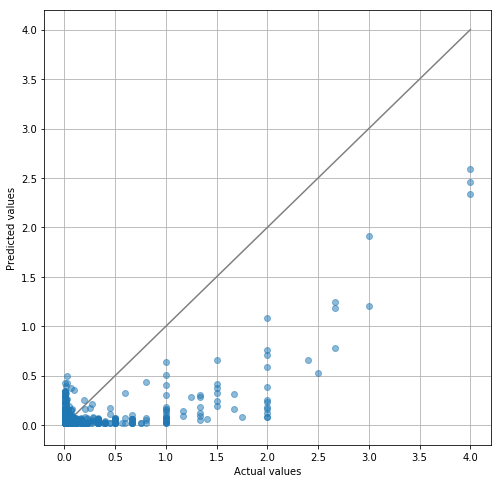

In [45]:
plt.figure(figsize=(8, 8))

plt.plot((0, 4), (0, 4), color='gray')
plt.plot(y, predictions, linewidth=0, marker='o', alpha=0.5)
plt.grid()
plt.xlim((-0.2, 4.2))
plt.ylim((-0.2, 4.2))
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.show()

The closer to the gray line, the more accurate the predicted value is.  
Then, at first glance I can understand the predocted values are not accurate.  
In addition, it is also understood that the prediction is pulled to a small value near 0, and a small prediction is made for the larger value.

Let's try logarithmic transformation of the target variable.

In [46]:
X = prepare_df.drop(['id', 'easily_accomodated'], axis=1)
y = np.log(prepare_df.easily_accomodated.values)

rf = RandomForestRegressor(n_estimators=100, max_depth=5)
scores = cross_val_score(rf, X, y, cv=5)
print(scores)

[0.24520125 0.13815219 0.16056958 0.10655798 0.19921753]


In [47]:
rf.fit(X, y)
predictions = rf.predict(X)

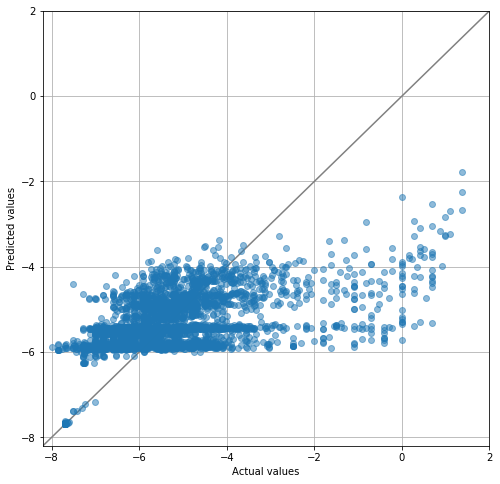

In [48]:
plt.figure(figsize=(8, 8))

plt.plot((-10, 10), (-10, 10), color='gray')
plt.plot(y, predictions, linewidth=0, marker='o', alpha=0.5)
plt.grid()
plt.xlim((-8.2, 2))
plt.ylim((-8.2, 2))
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.show()

It has improved somewhat, but the values are still too dense and many predicted values have been pulled into that part.
To improve this, I think two method are effective.

* Review the logic of the objective variable; this definition maybe too complex, it maybe good with more simple definition of target valuables.  
* Do downsampling in dense areas.

This analysis doesn't cover that much, but I'm going to add it if there is something in the future.

## Summary

This notebook uses data from the Seattle area of Airbnb and has been analyzed to answer the following questions.
Here we summarize the answers to those questions.

* **How long is the period available for lending by rooms?**  
The histogram of maximum nights shows that there are two groups.    
One is a listing that can be used at spots such as the maximum number of nights within a week.  
The other is a listing that supports a wide range of stay from the super long-term stay of the maximum number of stays for three years or more and the minimum number of nights for around two days to the spot use. 


* **Is there a busy season?**   
The answer is **Yes**.  
Apart from the increase in the number of Airbnb users, there was definitely a timely increase in the number of reviews at the same time each year.  
It is thought that it is about one month around early September and overlaps with the summer vacation time. It is important that the number of properties that can be provided at this time exceeds demand.


* **Are there any trends of popular rooms?**  
I could not derive it from my analysis.  
However, I learned that the score improves by logarithmic transformation. I will find time in the future and try to improve.